Логистическая регрессия

И в линейной и в логистической регрессии используется линейная функция. Только в линейной регрессии она используется для предсказания значений, а в логистической - для предсказания отнесения к одному из двух классов (0 или 1, да или нет, и т.д.)

Классы разделяются поверхностью, в зависимости от кол-ва фичей это может быть линия, плоскость или гиперплоскость (многомерная плоскость)

Чем дальше значения лежат от разделяющей поверхности, тем уверенее модель относит объект к тому или иному классу. Но по абсолютным значениям нельзя сказать, насколько мы далеко от некой точки. Поэтому абсолютные числа надо перевести в относительные. Сделать это можно прогоняя числа через функцию сигмоиды. В результате получим числа в диапазоне от 0 до 1.

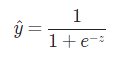

z - ответы линейной функции

Чем больше значение логита, тем дальше оно будет от разделяющей линии и тем ближе значение будет к 1 после применения функции сигмоиды (т.е. тем выше уверенность). Отрицательные значения будут меньше 0.5 – это значит, что они принадлежат другому классу. Чем ближе логиты к разделяющей плоскости, тем ближе будут значение к 0.5 после применения сигмоиды – т.е. модель меньше будет уверена в ответе.


В некоторых библиотеках машинного обучения значения, полученные после сигмоиды, называются predict_proba.

LogLoss

LogLoss - функция потерь логистической регрессии

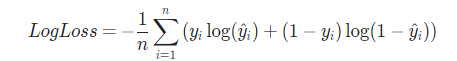

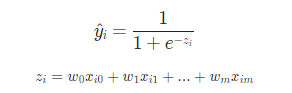

Выражая в матричном виде, получим

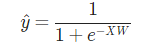

Градиент по функции потерь:

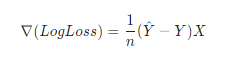